In [1]:
# 画像の読み込み
# $bash copy_image.sh　実行後のディレクトリ構成
# ref: https://qiita.com/ba--shi/items/09f5f2f119ffbd9bb316
import os
import cv2 # dockerの場合　$apt install libgl1-mesa-dev
import matplotlib.pyplot as plt

def modify_image(img, width, height):
    """指定した大きさに収まるように、アスペクト比を固定して、リサイズする。
       ref: https://camp.trainocate.co.jp/magazine/python-opencv/
    """
    h, w = img.shape[:2]
    aspect = w / h
    if width / height >= aspect:
        nh = height
        nw = round(nh * aspect)
    else:
        nw = width
        nh = round(nw / aspect)

    scaled = cv2.resize(img, dsize=(nw, nh))
    h_padding = round((height - nh) / 2)
    w_padding = round((width - nw) / 2)
    dst = cv2.copyMakeBorder(scaled, h_padding, height - nh - h_padding, w_padding, width- nw - w_padding, cv2.BORDER_REPLICATE)

    return dst

image_list = []
label_list = []
IMAGE_SIZE = 450
BASE_DIR = os.getcwd()

for dir in os.listdir(BASE_DIR + "/images"):
    img_dir =  BASE_DIR + "/images/" + dir
    # フォルダごとにラベル分けする
    label = dir
    
    for file in os.listdir(img_dir):
        # 配列label_listに正解ラベルを追加
        label_list.append(label)
        # 配列image_listに画像の配列データを追加
        filepath = img_dir + "/" + file
        img = cv2.imread(filepath)
        image = modify_image(img, IMAGE_SIZE, IMAGE_SIZE)
        # cv2.imwrite(f'modifyed/{file}', image)
        # plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        # plt.show()
        # image = img_to_array(img)
        image_list.append(image)

In [2]:
import tensorflow as tf
import numpy as np

X = np.asarray(image_list).astype('float32') / 255.0

N_CLASSES = 15
Y = np.asarray(label_list)
Y = tf.keras.utils.to_categorical(Y, N_CLASSES)

print(X.shape, Y.shape)

from sklearn.model_selection import train_test_split

TEST_SIZE = 0.2
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=TEST_SIZE, stratify=Y, random_state=0)

2023-10-15 08:13:25.313899: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-15 08:13:25.885127: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-15 08:13:25.885157: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-15 08:13:25.887927: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-15 08:13:26.154521: I tensorflow/core/platform/cpu_feature_g

(314, 500, 500, 3) (314, 15)


In [3]:
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    zoom_range=0.5,
    rotation_range=45,
    height_shift_range=0.1,
    width_shift_range=0.1,
    channel_shift_range=0.1,
)
train_generator = data_generator.flow(train_x, train_y, batch_size=32, shuffle=True)
# batch_x = train_iter.next()
# print(batch_x[0])
# batch_x = batch_x.astype(np.uint8)
# plt.figure(figsize=(10,10))
# for i in range(32):
#     plt.subplot(4,8,i+1)
#     plt.imshow(batch_x[i])

In [4]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        patience=2,
        restore_best_weights=True
    ),
    # ModelCheckpointのソースを書き換える
    # 右クリックで定義に移動 → Ctrl + F で'option=self._option'を検索 → 該当箇所をコメントアウト
    tf.keras.callbacks.ModelCheckpoint(
        'data/temp/road_sign_sequential_{epoch:03d}_{val_loss:.4f}.keras',
        save_best_only=True
    ),
    # tf.keras.callbacks.TensorBoard(
    #     log_dir='logs',
    #     histogram_freq=1
    # ),
]

In [5]:
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.applications import VGG16

vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
for layer in vgg_model.layers:
    layer.trainable = False
    
x = vgg_model.output
x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(4, 4))(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
output = Dense(N_CLASSES, activation='softmax')(x)

BATCH_SIZE = 32
EPOCHS = 30

model = tf.keras.Model(inputs=vgg_model.input, outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(train_generator, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose='1', validation_data=(test_x, test_y), callbacks=callbacks)
# history = model.fit(train_x, train_y, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose='1', validation_data=(test_x, test_y), callbacks=callbacks)
model.save('model.keras')

2023-10-15 08:13:30.817086: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-15 08:13:30.859739: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-15 08:13:30.859800: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-15 08:13:30.863859: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-15 08:13:30.863995: I tensorflow/compile

Epoch 1/10


2023-10-15 08:13:36.974208: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2023-10-15 08:13:55.179632: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f8d7c116080 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-15 08:13:55.179687: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1070, Compute Capability 6.1
2023-10-15 08:13:55.189614: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-15 08:13:55.278987: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


<Axes: >

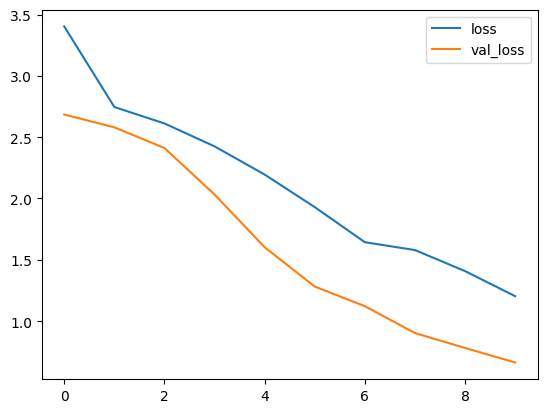

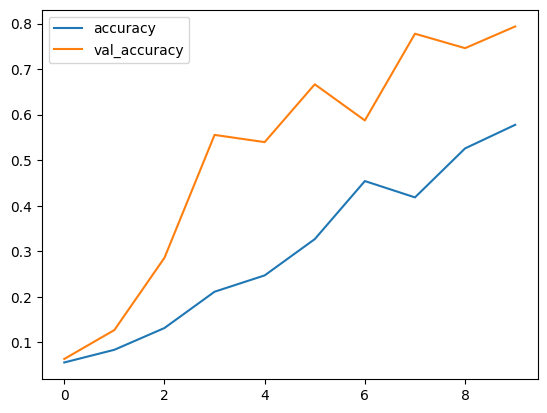

In [6]:
import pandas as pd

hist_df = pd.DataFrame(history.history)
hist_df[['loss', 'val_loss']].plot()
hist_df[['accuracy', 'val_accuracy']].plot()

In [7]:
score = model.evaluate(test_x, test_y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

2/2 [==============================] - 1s 535ms/step - loss: 0.6626 - accuracy: 0.7937
Test loss: 0.6626458168029785
Test accuracy: 0.7936508059501648
